Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_92 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_93 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 dropout_85 (Dropout)        (None, 12, 12, 64)        0         
                                                                 
 flatten_37 (Flatten)        (None, 9216)              0         
                                                                 
 dense_81 (Dense)            (None, 128)      

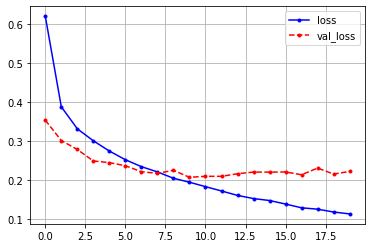

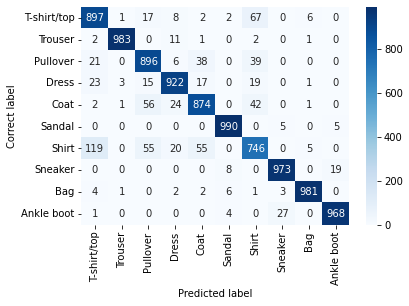

In [84]:
import tensorflow as tf
from tensorflow import keras
import keras.preprocessing
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math
import sys
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


#데이터 불러오기
fashion_mnist = keras.datasets.fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()


label_map  = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('Train: X=%s, y=%s' % (X_train.shape, Y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, Y_test.shape))

"""
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(train_images[i], cmap=plt.get_cmap('gray'))
"""


X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=100)

#print("Train set 이미지 수: {} 개".format(X_train.shape[0]))
#print("Validation set 이미지 수: {} 개".format(X_val.shape[0]))


# CNN
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

Y_train = np_utils.to_categorical(Y_train)
Y_val = np_utils.to_categorical(Y_val)
Y_test = np_utils.to_categorical(Y_test)



model = Sequential()

model.add(Conv2D(32, kernel_size = (3,3), input_shape=(28,28,1), activation='relu'))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# model = Sequential()
# model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
#                  data_format='channels_last', input_shape=(28,28,1)))
# model.add(BatchNormalization())

# model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
#                  data_format='channels_last'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
#                  data_format='channels_last'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
    
    
# model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
#                  data_format='channels_last'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
# model.add(Dense(10, activation='softmax'))
model.summary()

model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

MODEL_DIR = "./model/"

if not os.path.exists(MODEL_DIR):
  os.mkdir(MODEL_DIR)

modelpath = './model/{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor = 'val_loss', verbose=1, save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)


epochs = 20
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), 
                    epochs=epochs, 
                    batch_size=200, 
                    verbose=0, 
                    callbacks=[early_stopping_callback, checkpointer])

print("\n Val Loss: %.4f" % (model.evaluate(X_val, Y_val)[0]))
print("\n Val Accuracy: %.4f" % (model.evaluate(X_val, Y_val)[1]))
print("\n Test Loss: %.4f" % (model.evaluate(X_test, Y_test)[0]))
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))

plt.figure(1)

# 오차
y_vloss = history.history['val_loss']

# 학습셋 오차
y_loss = history.history['loss']

# 그래프로 표현
x_len = [i for i in range(epochs)]
plt.plot(x_len, y_loss, marker = '.', c='blue', label = 'loss')
plt.plot(x_len, y_vloss, marker = '.', c="red",  linestyle = "--",label='val_loss')



# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()



# 정확도
y_vaccuracy = history.history['val_accuracy']

# 학습셋
y_accuracy = history.history['accuracy']

plt.show()

# Calculate confusion matrix
predictions = model.predict(X_test)
label = [np.argmax(i) for i in Y_test]
pred_label = [np.argmax(i) for i in predictions]


conf_matrix = confusion_matrix(label, pred_label)

# display confusion matrix as heatmap
ax = sns.heatmap(conf_matrix, 
            cmap='Blues', 
            xticklabels=label_map, 
            yticklabels=label_map,
            annot=True,
            fmt='d')

plt.xlabel('Predicted label') 
plt.ylabel('Correct label') 

plt.show()

In [81]:
import tensorflow as tf
from tensorflow import keras
import keras.preprocessing
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import math
import sys
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


#데이터 불러오기
fashion_mnist = keras.datasets.fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()


label_map  = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('Train: X=%s, y=%s' % (X_train.shape, Y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, Y_test.shape))

"""
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(train_images[i], cmap=plt.get_cmap('gray'))
"""


X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=100)

#print("Train set 이미지 수: {} 개".format(X_train.shape[0]))
#print("Validation set 이미지 수: {} 개".format(X_val.shape[0]))


# CNN
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

Y_train = np_utils.to_categorical(Y_train)
Y_val = np_utils.to_categorical(Y_val)
Y_test = np_utils.to_categorical(Y_test)


"""
model = Sequential()

model.add(Conv2D(32, kernel_size = (3,3), input_shape=(28,28,1), activation='relu'))
model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
"""

IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 28, 28, 1, 10
model = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
               input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS)),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),        
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),    
        MaxPooling2D(pool_size=(2, 2)),   
        
        Flatten(),
        
        Dense(1024, activation='relu'),
        
        Dense(512, activation='relu'),
        
        Dense(NUM_CLASSES, activation='softmax')
    ])
    
adam = Adam(lr=0.0001, decay=1e-6)
model.compile(optimizer=adam,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

MODEL_DIR = "./model/"

if not os.path.exists(MODEL_DIR):
  os.mkdir(MODEL_DIR)

modelpath = './model/{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor = 'val_loss', verbose=1, save_best_only=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)


history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), 
                    epochs=25, 
                    batch_size=32, 
                    verbose=0, 
                    callbacks=[early_stopping_callback, checkpointer])

print("\n Val Loss: %.4f" % (model.evaluate(X_val, Y_val)[0]))
print("\n Val Accuracy: %.4f" % (model.evaluate(X_val, Y_val)[1]))
print("\n Test Loss: %.4f" % (model.evaluate(X_test, Y_test)[0]))
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))

plt.figure(1)

# 오차
y_vloss = history.history['val_loss']

# 학습셋 오차
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss, marker = '.', c='blue', label = 'loss')
plt.plot(x_len, y_vloss, marker = '.', c="red",  linestyle = "--",label='val_loss')



# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()



# 정확도
y_vaccuracy = history.history['val_accuracy']

# 학습셋
y_accuracy = history.history['accuracy']

plt.show()

# Calculate confusion matrix
predictions = model.predict(X_test)
label = [np.argmax(i) for i in Y_test]
pred_label = [np.argmax(i) for i in predictions]


conf_matrix = confusion_matrix(label, pred_label)

# display confusion matrix as heatmap
ax = sns.heatmap(conf_matrix, 
            cmap='Blues', 
            xticklabels=label_map, 
            yticklabels=label_map,
            annot=True,
            fmt='d')

plt.xlabel('Predicted label') 
plt.ylabel('Correct label') 

plt.show()

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)

Epoch 1: val_loss improved from inf to 0.31296, saving model to ./model/01-0.3130.hdf5


KeyboardInterrupt: ignored

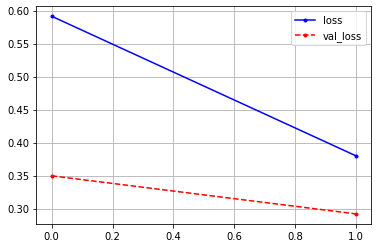

In [57]:
plt.figure(1)

# 오차
y_vloss = history.history['val_loss']

# 학습셋 오차
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss, marker = '.', c='blue', label = 'loss')
plt.plot(x_len, y_vloss, marker = '.', c="red",  linestyle = "--",label='val_loss')



# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()



# 정확도
y_vaccuracy = history.history['val_accuracy']

# 학습셋
y_accuracy = history.history['accuracy']

plt.show()

In [77]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=100)

